In [243]:
!gpustat

blade.seas.upenn.edu  Mon Sep 27 13:08:58 2021  455.45.01
[0] RTX A6000        | 32'C,   0 % | 44884 / 48685 MB | wangh19(44881M)
[1] RTX A6000        | 45'C,   2 % | 44152 / 48685 MB | xinyul(44149M)
[2] RTX A6000        | 59'C,   2 % | 44152 / 48685 MB | xinyul(44149M)
[3] RTX A6000        | 77'C,  99 % | 45064 / 48685 MB | shyamss(45061M)
[4] RTX A6000        | 30'C,   0 % |     1 / 48685 MB |
[5] RTX A6000        | 29'C,   0 % |     1 / 48685 MB |
[6] RTX A6000        | 30'C,   0 % |     1 / 48685 MB |
[7] RTX A6000        | 29'C,   0 % |     1 / 48685 MB |


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import numpy as onp
from numpy import fft
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jaxpinns.optimizers import mdmm_adam

import neural_tangents as nt
import operator

from jax.scipy.stats.norm import logpdf, pdf


from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [4]:
path = ''

In [5]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [6]:
exec(open('../helpers.py').read())

In [7]:
key = random.PRNGKey(0)

In [8]:
def fun_gen(key, freq, N):
    def fun(X):
        components = (np.array([A * np.sin(f * np.pi * X) for A, f in zip(2 * random.uniform(key, shape = (N,)), freq * random.uniform(random.split(key)[0],shape = (N,)))]))
        return components.sum((0))
    return fun
        

In [9]:
data_size = 2 ** 12

In [10]:
max_freq = 32
N_freq = 4
target_fn = fun_gen(key, max_freq, N_freq)

X = random.uniform(key, shape = (data_size, 1), minval = -1, maxval = 1)
Y = target_fn(X)
Y = Y + random.normal(random.split(key)[0], shape = Y.shape)*Y.std(0)*0.1
mu_X, sigma_X = X.mean(0), X.std(0)
X = (X - mu_X) / sigma_X
mu_Y, sigma_Y = Y.mean(0), Y.std(0)
Y = (Y - mu_Y) / sigma_Y

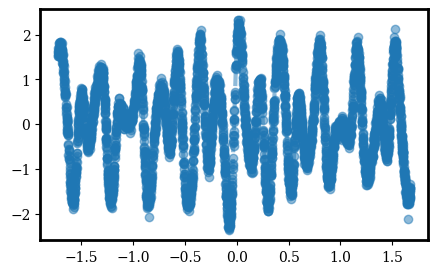

In [11]:
batch = (X, Y)

X_test = np.linspace(-1,1,400).reshape(-1,1)

Y_test = (target_fn(X_test) - mu_Y) / sigma_Y
X_test = (X_test - mu_X) / sigma_X

plt.figure(figsize = (5,3))
plt.plot(X_test, Y_test, linewidth = 3, linestyle = '--', alpha = 0.5, label = 'Target')
plt.scatter(X, Y, alpha = 0.5, label = 'Data')
plt.show()
plt.close()

In [12]:
layers = [X.shape[1], *[64 for _ in range(4)], 1]
activation = np.tanh
fit_model = MLPRegression(layers, activation = activation)

In [13]:
init_model = initNet(layers[:-1], activation = activation)
#init_model.plot_degree(init_model.scale_params, fit_model.net_params[:-1], X, word = False)

In [14]:
lr = 5e-3
init_fn, update_fn, get_params = optimizers.adam(lr)
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)
lam = 5e-4
@jit
def step(i, state, X):
    key = random.PRNGKey(i)
    g = grad(init_model.regulated_logSineLoss)(get_params(state), init_model.net_init(key), X, lam = lam)
    return update_fn(i, g, state)

In [15]:
opt_state = init_fn(init_model.scale_params)
init_nIter = 10000
pbar = trange(init_nIter)
scale_stor = []
bias_stor = []

for i in pbar:
    opt_state = step(i, opt_state, X)
    
    if i % 100 == 0:
        params = get_params(opt_state)
        pbar.set_postfix({'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), X)})
        scale_stor.append([w for (w, b) in params])
        bias_stor.append([b for (w, b) in params])
        

scale_stor = np.array(scale_stor)
bias_stor = np.array(bias_stor)
        


100%|██████████| 10000/10000 [00:08<00:00, 1226.98it/s, Log sine loss=0.3058052]


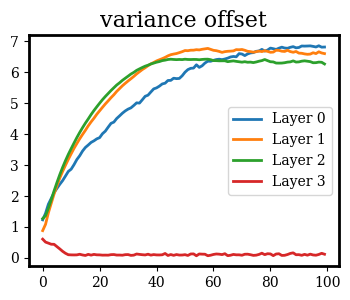

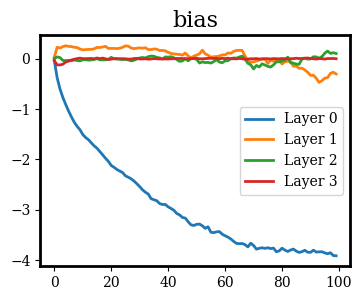

In [16]:
plt.figure(figsize = (4,3))
for i, s in enumerate(scale_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
plt.legend()
plt.title('variance offset')
plt.show()
plt.close()

plt.figure(figsize = (4,3))
for i, s in enumerate(bias_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
plt.legend()
plt.title('bias')
plt.show()
plt.close()

In [17]:
scale_params = params

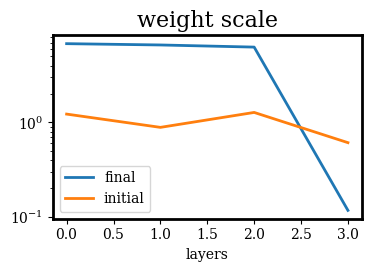

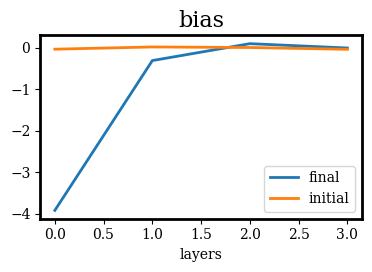

In [18]:
plt.figure(figsize = (4,3))

plt.plot([w_init for w_init, b_init in scale_params], label = 'final')
plt.plot([w_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.yscale('log')
plt.xlabel('layers')
plt.legend()
plt.title('weight scale')
plt.tight_layout()

plt.show()
plt.close()

plt.figure(figsize = (4,3))

plt.plot([b_init for w_init, b_init in scale_params], label = 'final')
plt.plot([b_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.xlabel('layers')
plt.legend()
plt.title('bias')
plt.tight_layout()

plt.show()
plt.close()

In [19]:
fit_model.scaled_net_params = parameter_scaling(fit_model.net_params[:-1], scale_params) + [fit_model.net_params[-1]]

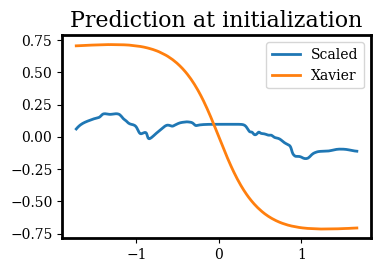

In [20]:
plt.figure(figsize = (4,3))
plt.plot(X_test, fit_model.net_apply(fit_model.scaled_net_params, X_test), label = 'Scaled')
plt.plot(X_test, fit_model.net_apply(fit_model.net_params, X_test), label = 'Xavier')
plt.title('Prediction at initialization')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [21]:
key = random.PRNGKey(3)

max_freq = 72
N_freq = 4
target_fn = fun_gen(key, max_freq, N_freq)

X = random.uniform(key, shape = (data_size, 1), minval = -1, maxval = 1)
Y = target_fn(X)
Y = Y + random.normal(random.split(key)[0], shape = Y.shape)*Y.std(0)*0.05
mu_X, sigma_X = X.mean(0), X.std(0)
X = (X - mu_X) / sigma_X
mu_Y, sigma_Y = Y.mean(0), Y.std(0)
Y = (Y - mu_Y) / sigma_Y

X_test = np.linspace(-1,1,400).reshape(-1,1)

Y_test = (target_fn(X_test) - mu_Y) / sigma_Y
X_test = (X_test - mu_X) / sigma_X

In [22]:
# lr = 1e-3
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)

init_fn, update_fn, get_params = optimizers.adam(optimizers.exponential_decay(1e-3, decay_steps = 400, decay_rate = 0.99))

@jit
def step(i, state, batch):
    g = grad(fit_model.loss)(get_params(state), batch)
    return update_fn(i, g, state)

In [23]:
nIter = 80000
pbar = trange(nIter)

opt_state = init_fn(fit_model.net_params)

loss_stor = []

for i in pbar:
    opt_state = step(i, opt_state, (X, Y))
    if i % 100 == 0:
        params = get_params(opt_state)
        loss_val = fit_model.loss(params, (X, Y))
        
        loss_stor.append(loss_val)
        pbar.set_postfix({'loss': loss_val})
        
loss_stor = np.array(loss_stor)

100%|██████████| 80000/80000 [00:27<00:00, 2865.83it/s, loss=0.32310587]


In [24]:
normal_opt_params = params

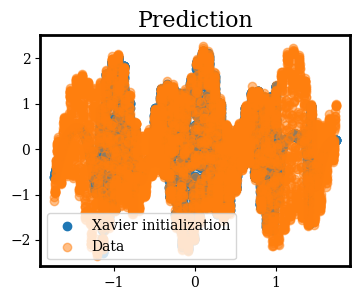

In [25]:
plt.figure(figsize = (4,3))

plt.scatter(X, fit_model.net_apply(params, X), label = 'Xavier initialization')
plt.scatter(X, Y, alpha = 0.5, label = 'Data')
plt.title('Prediction')
plt.legend()
plt.show()
plt.close()

In [26]:
pbar = trange(nIter)

opt_state = init_fn(fit_model.scaled_net_params)

scaled_loss_stor = []

for i in pbar:
    opt_state = step(i, opt_state, (X, Y))
    if i % 100 == 0:
        params = get_params(opt_state)
        loss_val = fit_model.loss(params, (X, Y))
        
        scaled_loss_stor.append(loss_val)
        pbar.set_postfix({'loss': loss_val})
        
scaled_loss_stor = np.array(scaled_loss_stor)

100%|██████████| 80000/80000 [00:27<00:00, 2929.69it/s, loss=0.0026740846]


In [27]:
scaled_opt_params = params

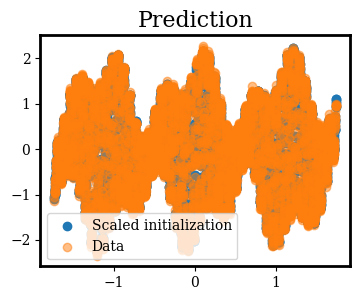

In [28]:
plt.figure(figsize = (4,3))

plt.scatter(X, fit_model.net_apply(params, X), label = 'Scaled initialization')
plt.scatter(X, Y, alpha = 0.5, label = 'Data')
plt.title('Prediction')
plt.legend()
plt.show()
plt.close()

In [29]:
# plt.figure(figsize = (4,3))
# plt.plot(100 * np.arange(loss_stor.shape[0] - scaled_loss_stor.shape[0], loss_stor.shape[0]), scaled_loss_stor, label = 'Scaled initialization')
# plt.plot(100 * np.arange(loss_stor.shape[0]), loss_stor, label = 'Xavier initialization')
# plt.axvline(init_nIter, linestyle = '--', color = 'k', label = 'Pre training')
# plt.yscale('log')
# plt.legend()
# plt.show()
# plt.close()

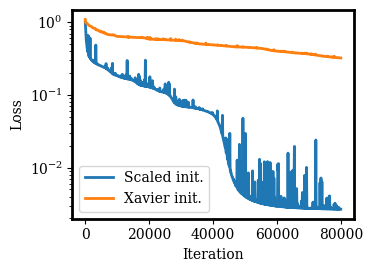

In [30]:
plt.figure(figsize = (4,3))
plt.plot(100 * np.arange(scaled_loss_stor.shape[0]), scaled_loss_stor, label = 'Scaled init.')
plt.plot(100 * np.arange(loss_stor.shape[0]), loss_stor, label = 'Xavier init.')
plt.yscale('log')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
# plt.savefig(path + f'{int(max_freq)}_loss.pdf', dpi = 200)
plt.show()
plt.close()

In [31]:
# np.save('train_data', np.array((X, Y)))
# np.save('test_data', np.array((X_test, Y_test)))

In [32]:
# with open(path + \
#           f'{lam}_{max_freq}_errors.txt', "w") as text_file:
#     text_file.write(f'initialization, train, test,\n')
#     text_file.write(f'Xavier, {fit_model.l2_error(normal_opt_params, (X, Y))}, {fit_model.l2_error(normal_opt_params, (X_test, Y_test))}, \n')
#     text_file.write(f'Scaled, {fit_model.l2_error(scaled_opt_params, (X, Y))}, {fit_model.l2_error(scaled_opt_params, (X_test, Y_test))}')


In [33]:
print(fit_model.l2_error(normal_opt_params, (X, Y)), fit_model.l2_error(normal_opt_params, (X_test, Y_test)))
print(fit_model.l2_error(scaled_opt_params, (X, Y)), fit_model.l2_error(scaled_opt_params, (X_test, Y_test)))

0.56842405 0.5632904
0.05171155 0.02223791


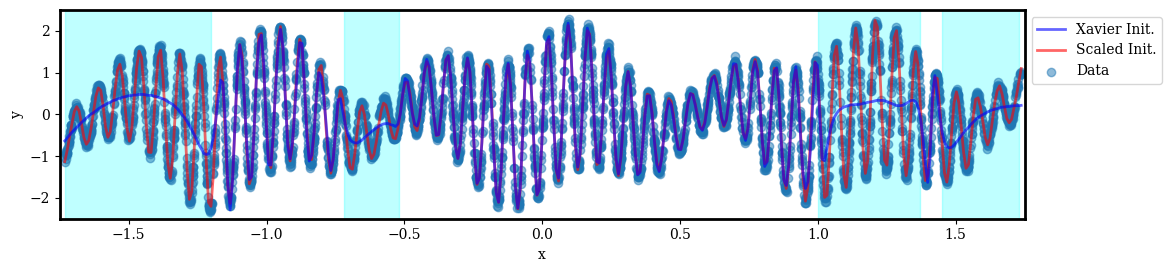

In [34]:
plt.figure(figsize = (12,3))
# plt.plot(X_test, Y_test, linewidth = 6, linestyle = '--', color = 'g', alpha = 0.5, label = 'Target', zorder = 0)
plt.scatter(X, Y, alpha = 0.5, label = 'Data', zorder = 1)
plt.plot(X_test, fit_model.net_apply(normal_opt_params, X_test), color = 'b', linewidth = 2, label = 'Xavier Init.', alpha = 0.6, zorder = 3)
plt.plot(X_test, fit_model.net_apply(scaled_opt_params, X_test), color = 'r', linewidth = 2, label = 'Scaled Init.', alpha = 0.6, zorder = 2)

plt.axvspan(-1.73, -1.2, alpha=0.25, color='aqua', zorder = -1)
plt.axvspan(-0.72, -0.52, alpha=0.25, color='aqua', zorder = -1)
plt.axvspan(1.0, 1.37, alpha=0.25, color='aqua', zorder = -1)
plt.axvspan(1.45, 1.73, alpha=0.25, color='aqua', zorder = -1)
plt.xlim([-1.75, 1.75])
plt.ylim([-2.5,2.5])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor = (1., 1.))
#plt.legend()
plt.tight_layout()
# plt.savefig(path + f'{int(max_freq)}_fit.pdf', dpi = 100)
plt.show()
plt.close()

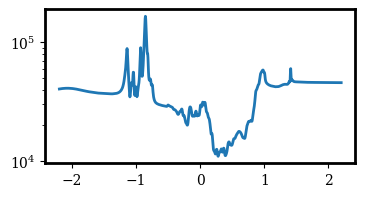

In [224]:
r_domain = 1.7
r_prox = 0.5
N_pt = 1000

sub_x_ntk = np.linspace(-(r_domain + r_prox), (r_domain + r_prox), N_pt).reshape(-1,1)
normal_ntk_mat = fit_model.ntk(normal_opt_params, sub_x_ntk)

plt.figure(figsize = (4,2))
plt.plot(sub_x_ntk, np.diag(normal_ntk_mat))
plt.yscale('log')
plt.show()
plt.close()

In [225]:
scaled_ntk_mat = fit_model.ntk(scaled_opt_params, sub_x_ntk)
# scaled_ntk_mat = scaled_ntk_mat / np.linalg.norm(scaled_ntk_mat)

normal_ntk_mat = fit_model.ntk(normal_opt_params, sub_x_ntk)
# normal_ntk_mat = normal_ntk_mat / np.linalg.norm(normal_ntk_mat)

In [226]:
diag = int(N_pt / 2 * (r_prox / r_domain))
K = np.arange(-diag, diag + 1)
normal_kernel = np.array([normal_ntk_mat[i, (i - diag) : (i + diag + 1)]for i in range(diag, normal_ntk_mat.shape[0] - diag)])
normal_kernel = np.abs(normal_kernel) / np.linalg.norm(normal_kernel)

In [227]:
diag

147

In [228]:
scaled_kernel = np.array([scaled_ntk_mat[i, (i - diag) : (i + diag + 1)]for i in range(diag, scaled_ntk_mat.shape[0] - diag)])
scaled_kernel = np.abs(scaled_kernel) / np.linalg.norm(scaled_kernel)

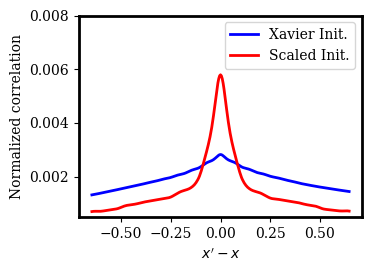

In [276]:
plt.figure(figsize = (4,3))
plt.plot(K * (sub_x_ntk[1:] - sub_x_ntk[:-1]).mean(), normal_kernel.mean(0), label = 'Xavier Init.', color = 'b')
plt.plot(K * (sub_x_ntk[1:] - sub_x_ntk[:-1]).mean(), scaled_kernel.mean(0), label = 'Scaled Init.', color = 'r')
plt.xlabel(r'$x^\prime - x$')
plt.ylabel('Normalized correlation')
# plt.yscale('log')
plt.legend(loc = 'upper right')
plt.yticks()
plt.ylim([5e-4, 8e-3])
plt.tight_layout()
plt.savefig('ntk_mat_decay.pdf', dpi = 100)
plt.show()
plt.close()


In [253]:
(K * (sub_x_ntk[1:] - sub_x_ntk[:-1]).mean()).shape

(295,)

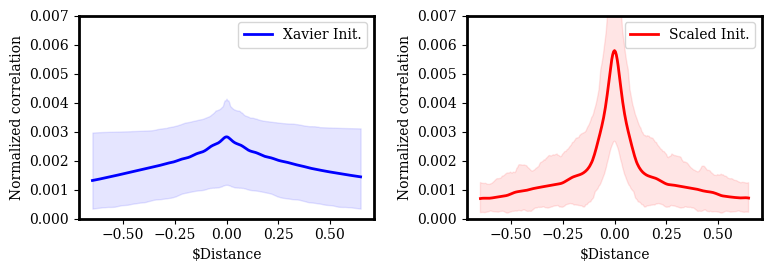

In [260]:
plt.figure(figsize = (8,3))
plt.subplot(1,2,1)
plt.plot(K * (sub_x_ntk[1:] - sub_x_ntk[:-1]).mean(),\
         normal_kernel.mean(0), label = 'Xavier Init.',\
         color = 'b', zorder = 5)
plt.fill_between(K * (sub_x_ntk[1:] - sub_x_ntk[:-1]).mean(),\
                 *np.quantile(normal_kernel, np.array([0.1, 0.9]), 0),\
                 color = 'b', alpha = 0.1, zorder = 0)
plt.xlabel(r'$Distance')
plt.ylabel('Normalized correlation')
# plt.yscale('log')
plt.legend(loc = 'upper right')
plt.ylim([0, 7e-3])
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(K * (sub_x_ntk[1:] - sub_x_ntk[:-1]).mean(),\
         scaled_kernel.mean(0), label = 'Scaled Init.',\
         color = 'r', zorder = 5)
plt.fill_between(K * (sub_x_ntk[1:] - sub_x_ntk[:-1]).mean(),\
                 *np.quantile(scaled_kernel, np.array([0.1, 0.9]), 0),\
                 color = 'r', alpha = 0.1, zorder = 0)
plt.xlabel(r'$Distance')
plt.ylabel('Normalized correlation')
# plt.yscale('log')
plt.legend(loc = 'upper right')
plt.ylim([0, 7e-3])
plt.tight_layout()


plt.savefig('ntk_mat_decay_2.pdf', dpi = 100)
plt.show()
plt.close()

In [230]:
xx, yy = np.meshgrid(K * (sub_x_ntk[1:] - sub_x_ntk[:-1]).mean(), sub_x_ntk[diag:-diag].reshape(-1))

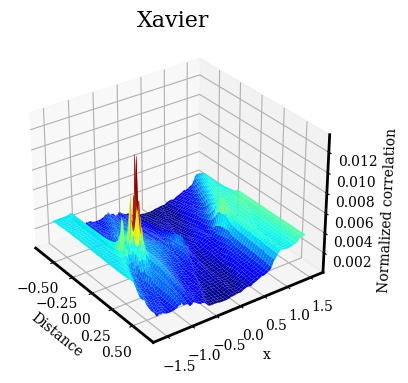

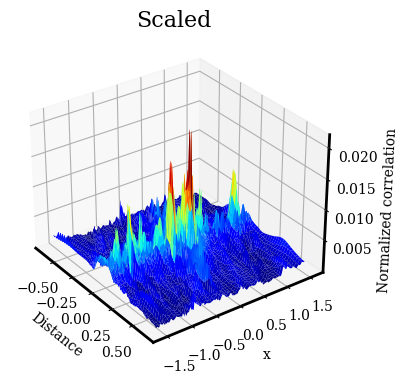

In [294]:
res = 200
elev = 30
azim = -36

fig = plt.figure(figsize = (5,4))

ax = fig.add_subplot(projection='3d')
ax.plot_surface(xx, yy, normal_kernel, antialiased=True, cmap='jet', linewidth=0)
ax.set_ylabel(r'x')
ax.set_xlabel('Distance')
ax.set_zlabel('Normalized correlation')
ax.set_title('Xavier')
# ax.set_zscale('log')
ax.view_init(azim=azim, elev=elev)




fig.tight_layout()

fig.savefig(path + '3d_contour_ntk_normal.pdf', dpi = 100)
plt.show()
plt.close()


fig = plt.figure(figsize = (5,4))

ax = fig.add_subplot(projection='3d')
ax.plot_surface(xx, yy, scaled_kernel, antialiased=True, cmap='jet', linewidth=0)
ax.set_ylabel(r'x')
ax.set_xlabel('Distance')
ax.set_zlabel('Normalized correlation')
ax.set_title('Scaled')
# ax.grid(False)
# ax.set_zscale('log')
ax.view_init(azim=azim, elev=elev)




fig.tight_layout()

fig.savefig(path + '3d_contour_ntk_scaled.pdf', dpi = 100)
plt.show()
plt.close()

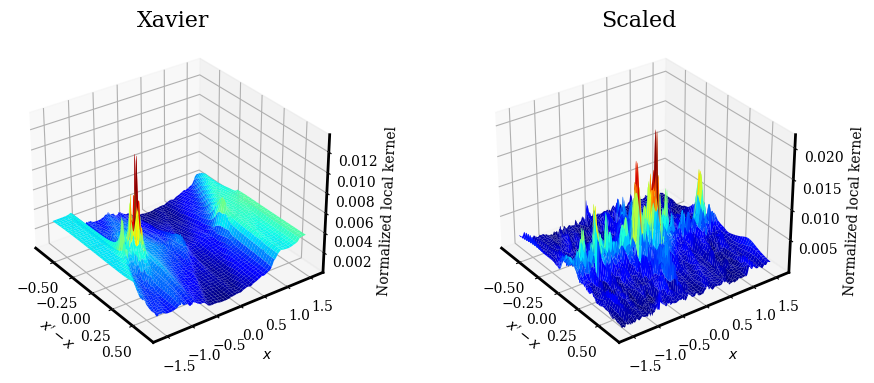

In [298]:
fig = plt.figure(figsize = (10,4))

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.plot_surface(xx, yy, normal_kernel, antialiased=True, cmap='jet', linewidth=0)
ax.set_ylabel(r'$x$')
ax.set_xlabel(r'$x^\prime - x$')
ax.set_zlabel('Normalized local kernel')
# ax.set_zlim([0, 0.008])
ax.set_title('Xavier')
# ax.set_zscale('log')
ax.view_init(azim=azim, elev=elev)


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(xx, yy, scaled_kernel, antialiased=True, cmap='jet', linewidth=0)
ax.set_ylabel(r'$x$')
ax.set_xlabel(r'$x^\prime - x$')
ax.set_zlabel('Normalized local kernel')
# ax.set_zlim([0, 0.008])
ax.set_title('Scaled')
# ax.grid(False)
# ax.set_zscale('log')
ax.view_init(azim=azim, elev=elev)

fig.tight_layout()

fig.savefig(path + '3d_contour_ntk.pdf', dpi = 100)
plt.show()
plt.close()

In [301]:
normal_kernel.shape

(706, 295)

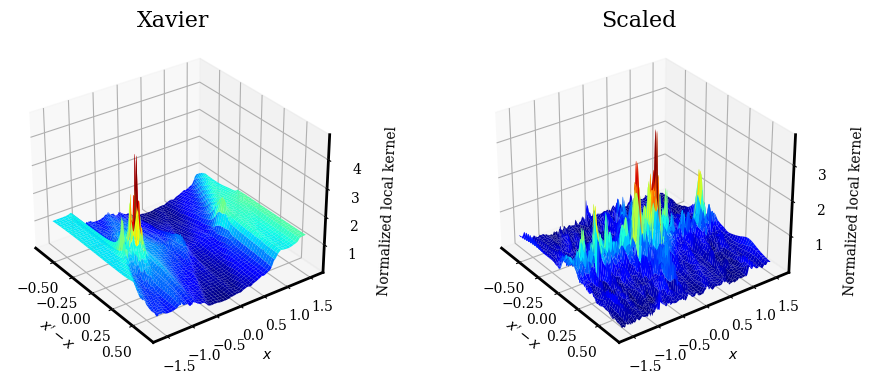

In [306]:
fig = plt.figure(figsize = (10,4))

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.plot_surface(xx, yy, normal_kernel/ normal_kernel[:, diag+1].mean(), antialiased=True, cmap='jet', linewidth=0)
ax.set_ylabel(r'$x$')
ax.set_xlabel(r'$x^\prime - x$')
ax.set_zlabel('Normalized local kernel')
# ax.set_zlim([0, 0.008])
ax.set_title('Xavier')
# ax.set_zscale('log')
ax.view_init(azim=azim, elev=elev)


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(xx, yy, scaled_kernel / scaled_kernel[:, diag+1].mean(), antialiased=True, cmap='jet', linewidth=0)
ax.set_ylabel(r'$x$')
ax.set_xlabel(r'$x^\prime - x$')
ax.set_zlabel('Normalized local kernel')
# ax.set_zlim([0, 0.008])
ax.set_title('Scaled')
# ax.grid(False)
# ax.set_zscale('log')
ax.view_init(azim=azim, elev=elev)

fig.tight_layout()

fig.savefig(path + 'normalized_3d_contour_ntk.pdf', dpi = 100)
plt.show()
plt.close()

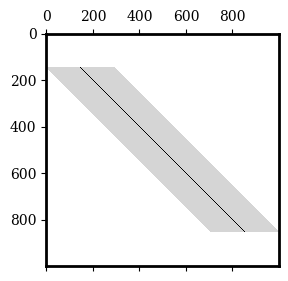

In [289]:
zero_mask = np.ones_like(normal_ntk_mat)
zero_mask = jax.ops.index_update(zero_mask, jax.ops.index[:diag, :], 0)
zero_mask = jax.ops.index_update(zero_mask, jax.ops.index[-diag:, :], 0)

zero_mask = np.triu(zero_mask, -diag) - np.triu(zero_mask, diag + 1)

diag_mat = np.diag(np.diag(zero_mask))

plt.figure(figsize=(4, 3))


m = plt.matshow(0.2 * (1 - zero_mask) + 1 - diag_mat, fignum = 1, cmap = 'gray')

plt.savefig(path+'mask_region.pdf',dpi = 100)
plt.show()
plt.close()